<a href="https://www.kaggle.com/code/fernandolima23/classification-rgb-heb-in-asterosesimology?scriptVersionId=233545485" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Classification (RGB / HeB) in asteroseismology

# Importing Libraries

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import seaborn as sbn
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from matplotlib.font_manager import FontProperties
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
import keras
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Reading the data

In [2]:
Data_RGB_HeB = pd.read_csv("../input/classification-in-asteroseismology/classification_in_asteroseismology.csv")
pd.set_option("display.max_columns", 4)
Data_RGB_HeB.head()

,POP,Dnu,numax,epsilon
0,1,4.44780,43.06289,0.985
1,0,6.94399,74.07646,0.150
2,1,2.64571,21.57891,0.855
3,1,4.24168,32.13189,0.840
4,0,10.44719,120.37356,0.275


# Data Preprocessing

Values of epsilon = -99.000 indicate that epsilon was unobtainable.

In [3]:
Data_RGB_HeB[Data_RGB_HeB == -99.000] = np.nan
Missing = Data_RGB_HeB.isnull().sum()/len(Data_RGB_HeB["Dnu"])
Missing

POP        0.0
Dnu        0.0
numax      0.0
epsilon    0.0
dtype: float64

In [4]:
Data_RGB_HeB = Data_RGB_HeB.dropna()
Missing = Data_RGB_HeB.isnull().sum()/len(Data_RGB_HeB["Dnu"])
Missing

POP        0.0
Dnu        0.0
numax      0.0
epsilon    0.0
dtype: float64

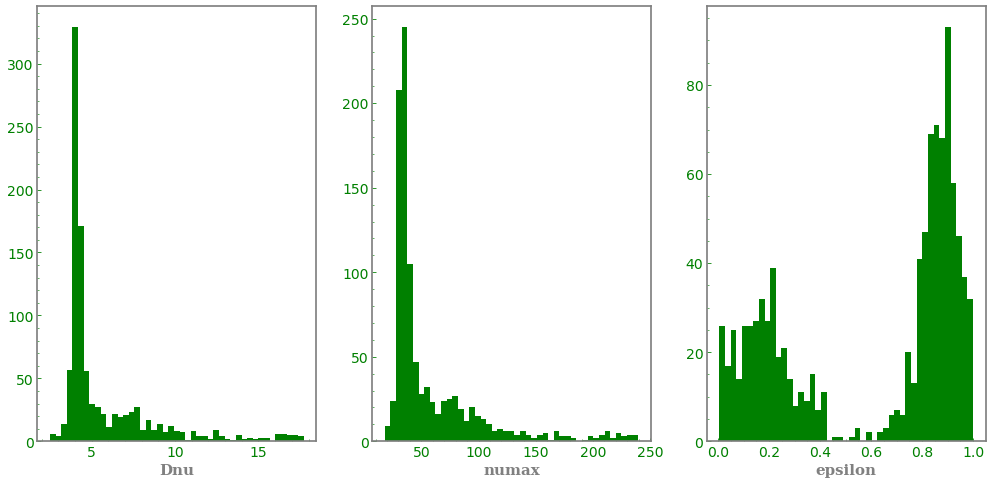

In [5]:
Fonte1 = {"family": "serif", "weight": "bold","color": "gray", "size":15 }
fig, axs = plt.subplots(nrows=1, ncols=3, figsize = (17, 8))
axs[0].hist(x = Data_RGB_HeB["Dnu"], color = "green", bins = 45)
axs[1].hist(x = Data_RGB_HeB["numax"], color = "green", bins = 45)
axs[2].hist(x = Data_RGB_HeB["epsilon"], color = "green", bins = 45)
axs[0].set_xlabel("Dnu", fontdict = Fonte1)
axs[1].set_xlabel("numax", fontdict = Fonte1)
axs[2].set_xlabel("epsilon", fontdict = Fonte1)
for i in range(0, 3):
    for axis in ["bottom", "left", "right", "top"]:
        axs[i].spines[axis].set_linewidth(1.7)
        axs[i].spines[axis].set_color("gray")
    axs[i].xaxis.set_minor_locator(AutoMinorLocator())
    axs[i].yaxis.set_minor_locator(AutoMinorLocator())
    axs[i].tick_params(axis = "both", direction = "in", labelcolor = "green", labelsize = 14)
    axs[i].tick_params(which = "minor", direction = "in", color = "green")
    axs[i].tick_params(which = "major", direction = "in", color = "green")    
fig.patch.set_color("white")
plt.show()

In [6]:
from pandas_profiling import ProfileReport
ProfileReport(Data_RGB_HeB)

Summarize dataset:   0%|          | 0/17 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Data split

In [7]:
y = Data_RGB_HeB["POP"]
y = pd.DataFrame(y, columns = ["POP"])
y_neural_network = np_utils.to_categorical(y)
x = Data_RGB_HeB.drop(["POP"], axis = 1)
x_train_neural_network, x_test_neural_network, y_train_neural_network, y_test_neural_network = train_test_split(x, y_neural_network, test_size = 0.3, random_state = 9)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state = 9)

# Models

## **Neural Network**

In [8]:
NN = Sequential()
NN.add(Dense(30, input_dim = 3, kernel_initializer = "normal", activation = "relu"))
NN.add(Dense(30, kernel_initializer = "normal", activation = "relu"))
NN.add(Dense(2, kernel_initializer = "normal", activation = "softmax"))

In [9]:
NN.compile(loss = "categorical_crossentropy", metrics=["acc"])
history = NN.fit(x_train_neural_network, y_train_neural_network, epochs = 3000, batch_size = 100, validation_data=(x_test_neural_network, y_test_neural_network), verbose = 0)

In [10]:
acc_test = history.history["val_acc"]
print(f"acc_max = {max(acc_test)}")
print(f"acc_min = {min(acc_test)}")

acc_max = 0.9734219312667847
acc_min = 0.6744186282157898


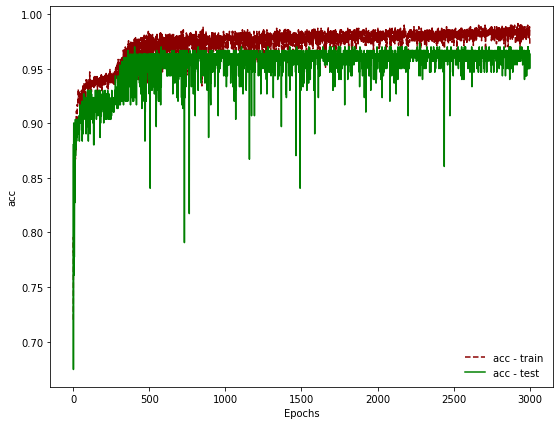

In [11]:
acc_train = history.history["acc"]
epochs = range(1, len(acc_train) + 1)
fig, ax = plt.subplots(figsize = (9, 7))
ax.plot(epochs, acc_train, "--g", color = "darkred", label = "acc - train")
ax.plot(epochs, acc_test, "-b", color = "green", label = "acc - test")
ax.legend(frameon = False)
ax.set_xlabel("Epochs")
ax.set_ylabel("acc")
fig.patch.set_facecolor("white")
plt.show()

## **GaussianNB**

In [12]:
NB = GaussianNB()
NB.fit(x_train, y_train)
y_prediction_NB = NB.predict(x_test)
print(accuracy_score(y_test, y_prediction_NB))

0.9136212624584718


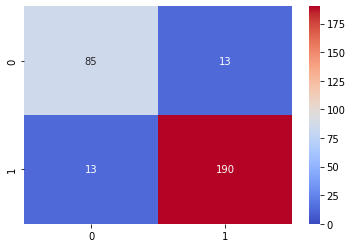

In [13]:
Matrix_NB = confusion_matrix(y_test, y_prediction_NB)
sbn.heatmap(Matrix_NB, annot = True, cmap = "coolwarm",vmin = 0, vmax = 190, fmt = "g")
plt.show()

In [14]:
y_proba_NB = NB.predict_proba(x_test)
y_proba_NB = y_proba_NB[:, 1]
fpr_NB, tpr_NB, thresholds_NB = roc_curve(y_test, y_proba_NB)

## **Random Forest**

In [15]:
warnings.filterwarnings('ignore')
Random_Forest = RandomForestClassifier()
max_depth = np.array([2, 3, 4, 5, 6, 7, 8, 9])
min_samples_split = np.array([2, 3, 4, 5, 6, 7, 8, 9])
param_grid = {"max_depth": max_depth, "min_samples_split": min_samples_split}
Grid_Random_Forest = GridSearchCV(estimator = Random_Forest, param_grid= param_grid, cv = 5, n_jobs = -1)
Grid_Random_Forest.fit(x_train, y_train.values.ravel())
print(f"Random Forest: max_depth = {Grid_Random_Forest.best_estimator_.max_depth} // min_samples_split = {Grid_Random_Forest.best_estimator_.min_samples_split}")

Random Forest: max_depth = 5 // min_samples_split = 7


In [16]:
Random_Forest = RandomForestClassifier(max_depth = 5, min_samples_split = 7)
Random_Forest.fit(x_train, y_train)
y_predict_Random_Forest = Random_Forest.predict(x_test)
print(accuracy_score(y_test, y_predict_Random_Forest))

0.9501661129568106


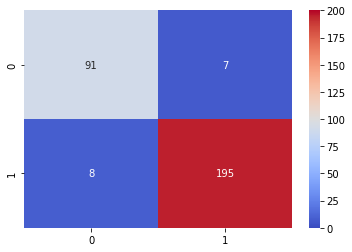

In [17]:
Matrix_Random_Forest = confusion_matrix(y_test, y_predict_Random_Forest)
sbn.heatmap(Matrix_Random_Forest, annot = True, cmap = "coolwarm", vmin = 0, vmax = 200, fmt = "g")
plt.show()

In [18]:
y_proba_Random_Forest = Random_Forest.predict_proba(x_test)
y_proba_Random_Forest = y_proba_Random_Forest[:, 1]
fpr_RF, tpr_RF, Ts_RF = roc_curve(y_test, y_proba_Random_Forest)

## **Gradient Boosting**

In [19]:
warnings.filterwarnings('ignore')
GradientBoosting = GradientBoostingClassifier(n_estimators=200)
learning_rate = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])
min_samples_split = np.array([2, 3, 4, 5, 6])
min_samples_leaf = np.array([2 , 3 ,4 ,5 ,6])
max_depth = np.array([2 , 3 ,4 ,5 ,6 ,7])
param_grid_GradientBoosting = {"learning_rate": learning_rate, "min_samples_split": min_samples_split, 
                              "min_samples_leaf": min_samples_leaf, "max_depth" : max_depth}
Grid_GradientBoosting = GridSearchCV(estimator = GradientBoosting, param_grid = param_grid_GradientBoosting, cv = 5, n_jobs=-1)
Grid_GradientBoosting.fit(x_train, y_train.values.ravel())
print(f"GradientBoosting: learning_rate  = {Grid_GradientBoosting.best_estimator_.learning_rate} // min_samples_split = {Grid_GradientBoosting.best_estimator_.min_samples_split} // min_samples_leaf = {Grid_GradientBoosting.best_estimator_.min_samples_leaf}")

GradientBoosting: learning_rate  = 0.4 // min_samples_split = 2 // min_samples_leaf = 5


In [20]:
print(f"max_depth = {Grid_GradientBoosting.best_estimator_.max_depth}")

max_depth = 5


In [21]:
GradientBoosting = GradientBoostingClassifier(n_estimators=200, learning_rate = 0.1, min_samples_split = 5, min_samples_leaf = 5, max_depth = 5)
GradientBoosting.fit(x_train, y_train)
y_predict_GB = GradientBoosting.predict(x_test)
print(accuracy_score(y_test, y_predict_GB))

0.9601328903654485


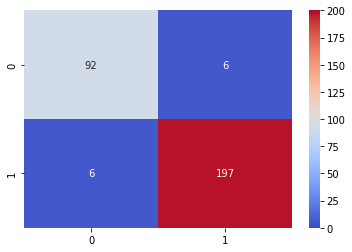

In [22]:
Matrix_GB = confusion_matrix(y_test, y_predict_GB)
sbn.heatmap(Matrix_GB, annot = True, cmap = "coolwarm",vmin = 0, vmax = 200, fmt = "g")
plt.show()

In [23]:
y_proba_GB = GradientBoosting.predict_proba(x_test)
y_proba_GB = y_proba_GB[:, 1]
fpr_GB, tpr_GB, Ts_GB = roc_curve(y_test, y_proba_GB)

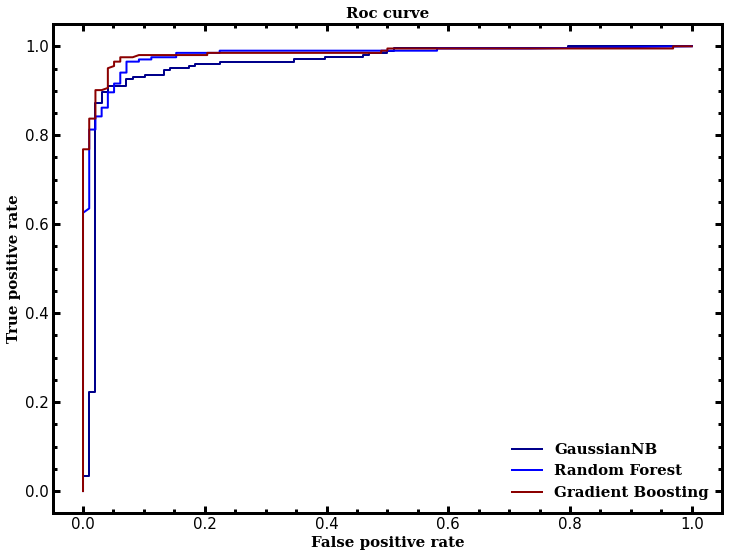

In [24]:
warnings.filterwarnings('ignore')
fig, ax = plt.subplots(figsize = (12, 9))
Fonte1 = {"family": "serif", "weight": "bold", "color": "black", "size": 15}
Fonte2 = {"family": "serif", "weight": "bold", "color": "black", "size": 15}
Fonte3 = FontProperties(family="serif",
                                   weight='bold',
                                   style='normal', 
                                     size=15)
ax.plot(fpr_NB, tpr_NB, label = "GaussianNB", color = "darkblue", linewidth = 2)
ax.plot(fpr_RF, tpr_RF, label = "Random Forest", color = "blue", linewidth = 2)
ax.plot(fpr_GB, tpr_GB, label = "Gradient Boosting", color = "darkred", linewidth = 2)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(axis = "both", direction = "in", labelcolor='black', labelsize=15, bottom = True, left = True, top = True, right = True)
ax.tick_params(which='major', direction = "in", color='black', length=7, width = 3)
ax.tick_params(which='minor', direction = "in", length=4, color='black', width = 3, top = True, right = True, bottom = True, left = True)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3) 
plt.legend(frameon = False, prop = Fonte3)
ax.set_xlabel("False positive rate", fontdict = Fonte1)
ax.set_ylabel("True positive rate", fontdict = Fonte1)
plt.title("Roc curve", fontdict = Fonte2)
fig.patch.set_facecolor("white")
plt.legend(frameon = False, prop = Fonte3)
plt.show()